In [1]:
from functools import partial
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial

import pysme.integrate as integ
import pysme.hierarchy as hier

In [2]:
%matplotlib inline

In [96]:
def rho_from_ket(ket):
    return np.outer(ket, ket.conj())

def vac_rho(n):
    ket = np.zeros(n + 1, dtype=np.complex)
    ket[0] = 1
    return rho_from_ket(ket)

def fock_proj(n, n_max):
    ket = np.zeros(n_max + 1, dtype=np.complex)
    ket[n] = 1
    return rho_from_ket(ket)

def truncated_squeezed_state(r, mu, m_max):
    ket = np.zeros(m_max + 1, dtype=np.complex)
    for n in range(m_max//2 + 1):
        ket[2*n] = (1 / np.sqrt(np.cosh(r))) * ((-0.5 * np.exp(2.j * mu) * np.tanh(r))**n /
                                                factorial(n)) * np.sqrt(factorial(2 * n))
    return ket / np.linalg.norm(ket)

def truncated_squeezed_rho(r, mu, m_max):
    ket = truncated_squeezed_state(r, mu, m_max)
    return rho_from_ket(ket)

In [4]:
def rect(x, a, b):
    return np.where(x < a, 0, np.where(x < b, 1, 0))

In [5]:
factory = hier.HierarchyIntegratorFactory(1, 6)

In [6]:
Id = np.eye(1, dtype=np.complex)
zero = np.zeros((1, 1), dtype=np.complex)

In [7]:
S = Id
L = zero
H = zero

In [8]:
integrator = factory.make_euler_jump_integrator(partial(rect, a=0, b=1),
                                                S, L, H, r=np.log(2), mu=0)

In [9]:
times = np.linspace(0, 1, 2**10)

In [10]:
solns = [integrator.integrate(Id, times, return_meas_rec=True)
         for n in range(512)]

In [11]:
counts = [rec.sum() for soln, rec in solns]

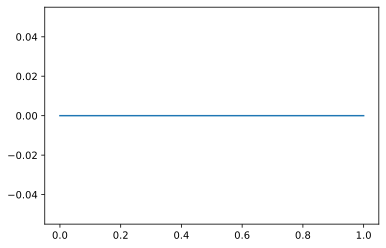

In [12]:
plt.plot(times, np.hstack([0, solns[3][1]]))

In [13]:
Counter(counts)

Counter({0: 293, 1: 162, 3: 52, 5: 5})

In [14]:
factory7 = hier.HierarchyIntegratorFactory(1, 7)

In [15]:
integrator7 = factory7.make_euler_jump_integrator(partial(rect, a=0, b=1),
                                                  S, L, H, r=np.log(2), mu=0)

In [16]:
solns7 = [integrator7.integrate(Id, times, return_meas_rec=True)
          for n in range(512)]

In [17]:
counts7 = [rec.sum() for soln, rec in solns7]

In [18]:
Counter(counts7)

Counter({2: 84, 0: 411, 4: 17})

In [42]:
factory20 = hier.HierarchyIntegratorFactory(1, 22)

In [58]:
integrator20 = factory20.make_euler_jump_integrator(partial(rect, a=0, b=1),
                                                    S, L, H, r=np.log(1.8), mu=0)

In [59]:
solns20 = [integrator20.integrate(Id, times, return_meas_rec=True)
           for n in range(32)]

In [60]:
counts20 = [rec.sum() for soln, rec in solns20]

In [61]:
Counter(counts20)

Counter({1: 26, 4: 1, 6: 1, 2: 4})

In [63]:
times21 = np.linspace(0, 0.5, 2**9)

In [79]:
factory21 = hier.HierarchyIntegratorFactory(1, 31)

In [80]:
integrator21 = factory21.make_euler_jump_integrator(partial(rect, a=0, b=0.5),
                                                    S, L, H, r=np.log(1.8), mu=0)

In [81]:
solns21 = [integrator21.integrate(Id, times21, return_meas_rec=True)
           for n in range(32)]

/Users/azaghal/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ode.py:1009: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  self.messages.get(istate, unexpected_istate_msg)))
/Users/azaghal/anaconda3/lib/python3.7/site-packages/pysme/sde.py:72: UserWarning: Integrator failed.
  warn('Integrator failed.')


In [82]:
counts21 = [rec.sum() for soln, rec in solns21]

In [83]:
Counter(counts21)

Counter({1: 2, 0: 30})

In [84]:
np.mean(counts21)

In [88]:
integrator21_n = factory21.make_euler_jump_integrator(partial(rect, a=0, b=0.5),
                                                      S, L, H, r=0, mu=0,
                                                      field_state=truncated_squeezed_state(r=np.log(1.8), mu=0,
                                                                                           m_max=31))

In [89]:
solns21_n = [integrator21_n.integrate(Id, times21, return_meas_rec=True)
             for n in range(32)]

In [90]:
counts21_n = [rec.sum() for soln, rec in solns21_n]

In [91]:
Counter(counts21_n)

Counter({0: 31, 2: 1})

In [92]:
np.mean(counts21_n)

In [93]:
soln_n_no_jump = integrator21_n.integrate_tr_dec_no_jump(Id, times21)

In [97]:
no_jump_traces = soln_n_no_jump.get_hierarchy_expectations(np.kron(Id,
                                                truncated_squeezed_rho(r=np.log(1.8), mu=0, m_max=31)))

In [98]:
no_jump_fock_probs = [soln_n_no_jump.get_hierarchy_expectations(np.kron(Id,
                                                                        fock_proj(n, 31)))
                      for n in range(32)]

In [102]:
no_jump_fock_probs[0].shape

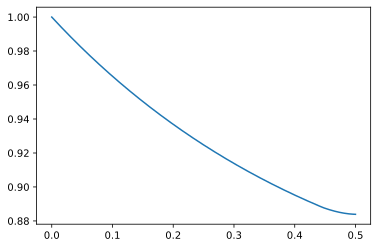

In [104]:
plt.plot(times21, no_jump_traces.flatten())

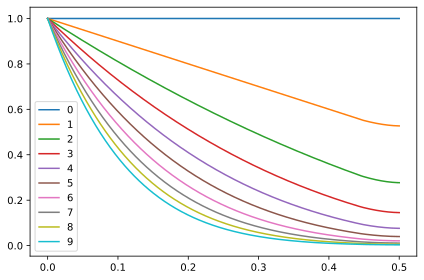

In [113]:
for n in range(10):
    plt.plot(times21, no_jump_fock_probs[n].flatten(), label=n)
plt.legend()
plt.tight_layout()

In [117]:
N = np.diag(range(32))
N

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  1,  0, ...,  0,  0,  0],
       [ 0,  0,  2, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 29,  0,  0],
       [ 0,  0,  0, ...,  0, 30,  0],
       [ 0,  0,  0, ...,  0,  0, 31]])

In [118]:
no_jump_mean_N = soln_n_no_jump.get_hierarchy_expectations(np.kron(Id,
                                                N @ truncated_squeezed_rho(r=np.log(1.8), mu=0, m_max=31)))

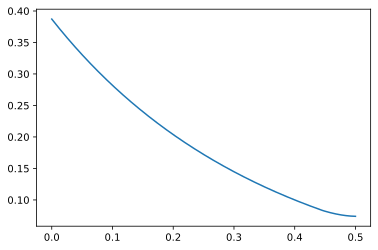

In [120]:
plt.plot(times21, no_jump_mean_N.flatten())